# Clasificación - Regresión Logística

Para esta actividad se buscará realizar un modelo de regresión logística para clasificación.


### Paso 1

Primero, importaremos la base de datos "auto_mpg.csv", obtenida y limpiada de un proyecto anterior.

In [26]:
import pandas as pd

df = pd.read_csv("auto_mpg.csv")
print(df.head(5))

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year                   car_name  origin_1  origin_2  origin_3  
0          70  chevrolet chevelle malibu         1         0         0  
1          70          buick skylark 320         1         0         0  
2          70         plymouth satellite         1         0         0  
3          70              amc rebel sst         1         0         0  
4          70                ford torino         1         0         0  


En este caso, las variables binarias "origin_1", "origin_2", "origin_3" representan si el carro de la observación es ya sea de estados unidos, de europa o asia respectivamente. Antes de tomar el curso de acción, veremos cuántas observaciones hay para cada valor.

In [27]:
print("Estados Unidos:",df.origin_1[df.origin_1 == 1].sum())
print("Europa:",df.origin_2[df.origin_2 == 1].sum())
print("Asia:",df.origin_3[df.origin_3 == 1].sum())

Estados Unidos: 245
Europa: 68
Asia: 79


Analizando los datos, debido a la proporción de los valores, considero que resultaría interesante enfocar el modelo en definir si un carro es de Estados Unidos o no, unificando las variables que indican que el carro es ya sea de europa o asia. Para esto, eliminaré las variables "origin_2" y "origin_3" para manejar la clasificación únicamente mediante los valores binarios de la variable "origin_1", siendo esta nuestra variable objetivo.

In [141]:
df = df.drop(columns=["car_name","origin_2", "origin_3"], errors="ignore") #También elimino "car_name" debido a irrelevancia.
print(df.head(5),"")

    mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin_1  
0          70         1  
1          70         1  
2          70         1  
3          70         1  
4          70         1   

Proporción datos originales: 1.6666666666666667


---
### Paso 2
A continuación, se separarán los datos en entrenamiento y prueba con una relación de 80/20, tratando de buscar un balance de clases, es decir, que la relación de valores de 1 y 0 sean similares en todos los conjuntos de datos. Para esto, buscaremos una semilla para la aleatorización de datos que nos de una proporción similar a la de los datos originales.


In [151]:
from sklearn.model_selection import train_test_split

y = df["origin_1"].astype(float)
X = df.drop(columns=[c for c in ["origin_1"] if c in df.columns], errors="ignore").copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=18
)

print("\nProporción datos originales:",df.origin_1.value_counts()[1]/df.origin_1.value_counts()[0])
print("Proporción train:",y_train.value_counts()[1]/y_train.value_counts()[0])
print("Proporción test:",y_test.value_counts()[1]/y_test.value_counts()[0])


Proporción datos originales: 1.6666666666666667
Proporción train: 1.6752136752136753
Proporción test: 1.6333333333333333


Con la semilla 18 obtenemos una proporciones con diferencias menores a 0.05, por lo que considero que son lo suficientemente similares para considerarse balanceada.  

---
### Paso 3
Ahora entrenaremos un modelo de regresión logística mediante el uso de la función LogisticRegression de la librería sklearn y se realizará una validación cruzada con este modelo mediante la función cross_val_score de la misma librería.

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logreg = LogisticRegression(penalty=None, class_weight="balanced", max_iter=1000)

cv_scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring="accuracy")

print("Resultados validación cruzada:", cv_scores)
print("Exactitud promedio:", cv_scores.mean())


Resultados validación cruzada: [0.87301587 0.82539683 0.85714286 0.93548387 0.91935484]
Exactitud promedio: 0.8820788530465948


Los resultados de la validación cruzada muestran un desempeño sólido del modelo de regresión logística, con una exactitud promedio del 88%. Esto significa que, en promedio, el modelo clasifica correctamente 9 de cada 10 autos al distinguir si son de Estados Unidos o de otra región. La variación entre folds (82% a 93%) indica cierta sensibilidad a los datos usados en el entrenamiento, pero en general refleja un modelo estable y confiable para este problema de clasificación binaria.

---
### Paso 4
Ahora se entrenará el modelo de regresión logística usando todo el conjunto de entrenamiento y luego se evaluará su desempeño en el conjunto de prueba.
A partir de las probabilidades predichas para la clase positiva (Estados Unidos = 1), calcularemos la matriz de confusión y reportaremos exactitud, sensibilidad y especificidad usando tres umbrales: uno estándar (0.5), uno menor (más sensible, 0.3) y uno mayor (más específico, 0.7).

In [166]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import numpy as np

# Entrenar el modelo con TODO el conjunto de entrenamiento
logreg = LogisticRegression(
    penalty=None,
    class_weight="balanced",
    max_iter=1000
)
logreg.fit(X_train, y_train)

# Obtener probabilidades en el conjunto de prueba
y_proba = logreg.predict_proba(X_test)[:, 1]

# Función auxiliar para evaluar un umbral
def evaluate_threshold(threshold: float):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
    tn, fp, fn, tp = cm.ravel()
    
    acc  = accuracy_score(y_test, y_pred)
    sens = recall_score(y_test, y_pred, pos_label=1)  # TPR, clase 1
    spec = recall_score(y_test, y_pred, pos_label=0)  # TNR, clase 0
    
    cm_df = pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"])
    return {
        "threshold": threshold,
        "confusion_matrix": cm_df,
        "accuracy": acc,
        "sensitivity": sens,
        "specificity": spec
    }

# 4) Evaluar en tres umbrales: menor, estándar 0.5 y mayor
thresholds = [0.3, 0.5, 0.7]
results = [evaluate_threshold(t) for t in thresholds]

# 5) Mostrar resultados
for res in results:
    print(f"\n=== Umbral: {res['threshold']:.2f} ===")
    print(res["confusion_matrix"])
    print(f"Exactitud     : {res['accuracy']:.3f}")
    print(f"Sensibilidad  : {res['sensitivity']:.3f}")
    print(f"Especificidad : {res['specificity']:.3f}")



=== Umbral: 0.30 ===
        Pred 0  Pred 1
Real 0      20      10
Real 1       4      45
Exactitud     : 0.823
Sensibilidad  : 0.918
Especificidad : 0.667

=== Umbral: 0.50 ===
        Pred 0  Pred 1
Real 0      27       3
Real 1       5      44
Exactitud     : 0.899
Sensibilidad  : 0.898
Especificidad : 0.900

=== Umbral: 0.70 ===
        Pred 0  Pred 1
Real 0      29       1
Real 1       7      42
Exactitud     : 0.899
Sensibilidad  : 0.857
Especificidad : 0.967


Los resultados muestran que el desempeño del modelo varía según el umbral utilizado. Con un umbral bajo (0.30), se obtiene una alta sensibilidad (0.918), lo que permite identificar correctamente la mayoría de autos de Estados Unidos, aunque con una menor especificidad (0.667), es decir, se confunden más autos extranjeros como estadounidenses. Con el umbral estándar de 0.50, se alcanza un equilibrio entre sensibilidad (0.898) y especificidad (0.900), logrando además la mayor exactitud global (0.899). Finalmente, al aumentar el umbral a 0.70, la sensibilidad disminuye (0.857), pero la especificidad se incrementa notablemente (0.967), reduciendo casi por completo la confusión de autos extranjeros, aunque a costa de perder algunos positivos.

---
### Paso 5
Ahora se evaluará el desempeño global del modelo mediante la curva ROC para observar la relación entre la tasa de verdaderos positivos (sensibilidad) y la tasa de falsos positivos a lo largo de diferentes umbrales de decisión. A partir de esta curva se calculará el área bajo la curva, que nos ayudará a medir la capacidad discriminativa del modelo. Si este valor es cercano a 1, indica un modelo con excelente capacidad de clasificación, mientras que un valor cercano a 0.5 refleja un desempeño similar al azar.

AUC: 0.948


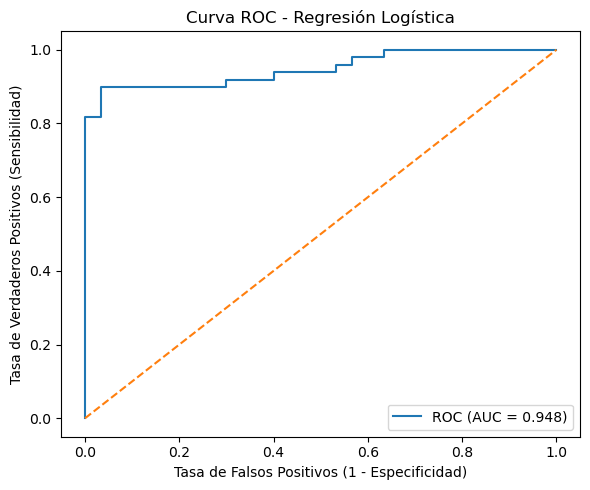

In [172]:
from sklearn.metrics import roc_curve, roc_auc_score

model = LogisticRegression(max_iter=1000, class_weight="balanced")
model.fit(X_train, y_train)
y_proba = model.predict_proba(X_test)[:, 1]

# Curva ROC y AUC
fpr, tpr, thr = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(f"AUC: {auc:.3f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


La curva ROC generada muestra que el modelo mantiene una tasa de verdaderos positivos alta mientras mantiene considerablemente controlada la tasa de falsos positivos. El valor de AUC cercano a 0.95 indica un muy buen poder discriminativo, es decir, aún si no es perfecto, el modelo es capaz de diferenciar con gran precisión entre autos de Estados Unidos y autos de otras regiones.

En términos prácticos, esto significa que, sin importar el umbral que se seleccione, el modelo conserva una buena capacidad para balancear sensibilidad y especificidad. 

---
### Paso 6
A continuación, obtendremos los coeficientes de las variables que conforman nuestro modelo para comprender la relevancia de éstas en el mismo.

In [174]:
# Extraer coeficientes del modelo entrenado
coef_df = pd.DataFrame({
    "Variable": X_train.columns,
    "Coeficiente": model.coef_[0]
}).sort_values(by="Coeficiente", ascending=False)

print(coef_df)


       Variable  Coeficiente
6    model_year     0.321965
5  acceleration     0.142688
2  displacement     0.129851
4        weight    -0.005988
3    horsepower    -0.033177
0           mpg    -0.222666
1     cylinders    -1.407297


* model_year (0.322)
Coeficiente positivo. Autos de años más recientes tienen mayor probabilidad de ser de Estados Unidos. Esto puede interpretarse como que la industria estadounidense fue más dominante en periodos posteriores, mientras que en años anteriores había más presencia de autos europeos o asiáticos.

* acceleration (0.143)
Coeficiente positivo. Autos con mayor aceleración (en segundos para alcanzar cierta velocidad) tienden a ser de Estados Unidos. Puede interpretarse como que los autos americanos de la época priorizaban potencia y tamaño, lo cual se traduce en aceleraciones más altas en promedio.

* displacement (0.130)
Coeficiente positivo. Un mayor desplazamiento del motor (volumen en cm³) aumenta la probabilidad de que el auto sea de Estados Unidos. Esto concuerda con el hecho de que los autos estadounidenses suelen tener motores más grandes que los europeos o asiáticos.

* weight (-0.006)
Coeficiente negativo, aunque muy cercano a cero. El peso tiene poca influencia en la clasificación; un ligero aumento en el peso se asocia con menor probabilidad de ser de Estados Unidos, pero el efecto es prácticamente despreciable.

* horsepower (-0.033)
Coeficiente negativo. Una mayor potencia del motor se asocia levemente con autos extranjeros. Esto podría reflejar que algunos autos europeos o asiáticos lograban más caballos de fuerza con motores más pequeños y eficientes.

* mpg (-0.223)
Coeficiente negativo. Autos con mayor rendimiento de combustible (más millas por galón) tienen menos probabilidad de ser estadounidenses. Podemos intuir que, en esa época, los autos americanos solían ser menos eficientes en consumo de gasolina comparados con los europeos y asiáticos.

* cylinders (-1.407)
Coeficiente fuertemente negativo. Autos con mayor número de cilindros tienden a ser extranjeros según el modelo. Esta es una señal interesante, porque en la realidad histórica los autos americanos solían tener muchos cilindros. Esto puede deberse a algún tipo de sesgo, las observaciones particulares que contenía el dataset y una infinidad de razones más. Sin embargo, el modelo generado logra un valor AUC de 0.95, lo cual indica que tiene una gran capacidad discriminativa, por lo que puedo ignorar la relevancia respecto al tema. 


### Conclusión

Las variables más influyentes en la clasificación son cylinders (negativa) y model_year (positiva).

Los autos más nuevos y con motores grandes (acceleration y displacement) tienden a clasificarse como estadounidenses.

En cambio, más cilindros y mayor eficiencia en combustible reducen la probabilidad de ser un auto de EE. UU., alineándose en parte con la tendencia de autos extranjeros más pequeños y eficientes.